# Support Vector Macines



## The Data

The data that we will be looking at is the 2018-2019 NBA season and seeing if we can correctly classify each player into their listed position. This includes: PG, SG, SF, PF and C.

Therefore first of all we need to load in the data and inspect it.

In [1]:
import pandas as pd

NBA = pd.read_csv("Data/NBA_tot.txt", sep=",", header = 0)

We want to see what columns are contained within the data so that we can remove any values that aren't necessary

In [2]:
print(NBA.columns.values)

['Rk' 'Player' 'Pos' 'Age' 'Tm' 'G' 'GS' 'MP' 'FG' 'FGA' 'FG%' '3P' '3PA'
 '3P%' '2P' '2PA' '2P%' 'eFG%' 'FT' 'FTA' 'FT%' 'ORB' 'DRB' 'TRB' 'AST'
 'STL' 'BLK' 'TOV' 'PF' 'PTS']


In this case we can drop the `Rk`, `Age`, `Tm`, `GS` ase these are not expected to be related to position and thus are not important going forward.

In [3]:
NBA.drop(columns =["Rk", "Age", "Tm", "GS"], inplace=True)

We then want to consider our target variable and how that is distributed and whether there may be any issues. We do this through a bar plot as we know that it is a discrete variable that takes on given categories.


Text(0, 0.5, 'Position')

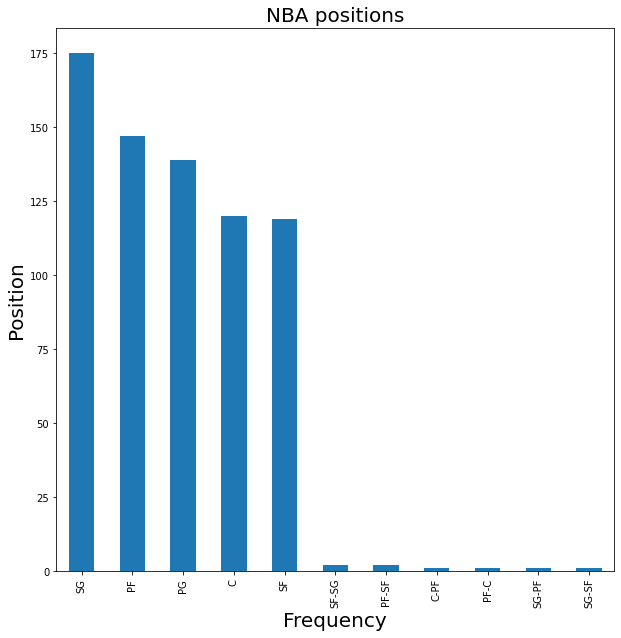

In [4]:
import matplotlib.pyplot as plt


pos = NBA.Pos.value_counts()
plt.subplots(figsize=(10, 10))
pos.plot(kind="bar")
plt.title("NBA positions", fontsize=20 )
plt.xlabel("Frequency", fontsize =20)
plt.ylabel("Position", fontsize=20 )

From this we can see that while SG, PF, PG, C and SF are all represented we have a few instances of players having two positions. The fact that these are so small means that we could potentially leave them out and drop them, but in our case we will try to clean them up on the basis that the first position identified will be their primary position.

We must thus inspect these outliers to see how appear.

In [5]:
NBA[NBA.Pos.isin(["PF-SF", "SF-SG","SG-PF","SG-SF", "PF-C", "C-PF"])]

,Player,Pos,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
38,Harrison Barnes\barneha02,PF-SF,77,2533,431,1027,0.420,174,441,0.395,...,0.824,57,304,361,115,50,13,98,122,1265
102,Jimmy Butler\butleji01,SF-SG,65,2185,418,904,0.462,67,193,0.347,...,0.855,121,221,342,263,123,39,95,111,1215
128,Wilson Chandler\chandwi01,PF-SF,51,1177,114,273,0.418,59,158,0.373,...,0.720,48,167,215,82,25,21,46,123,305
378,Kyle Korver\korveky01,SG-PF,70,1334,201,483,0.416,138,348,0.397,...,0.822,9,153,162,81,25,12,59,106,600
426,Thon Maker\makerth01,C-PF,64,972,109,268,0.407,49,153,0.320,...,0.667,41,161,202,45,21,51,33,105,323
436,Wesley Matthews\matthwe02,SF-SG,69,2091,279,698,0.400,150,403,0.372,...,0.810,32,138,170,160,54,17,91,160,840
600,Jonathon Simmons\simmojo02,SG-SF,56,1064,133,350,0.380,28,104,0.269,...,0.742,27,99,126,128,29,15,68,89,366
611,Jason Smith\smithja02,PF-C,20,190,21,59,0.356,9,26,0.346,...,0.875,16,36,52,14,3,7,13,30,65


We can thus use the apply function to be able to alter these results so that they show their primary position.

In [6]:
NBA["Pos"]= NBA["Pos"].apply(lambda x: x.split("-")[0] if "-" in x else x)

And check the results to see how they are distributed, expecting that this won't be too different to the plot above but that the double positions will be removed.

Text(0, 0.5, 'Position')

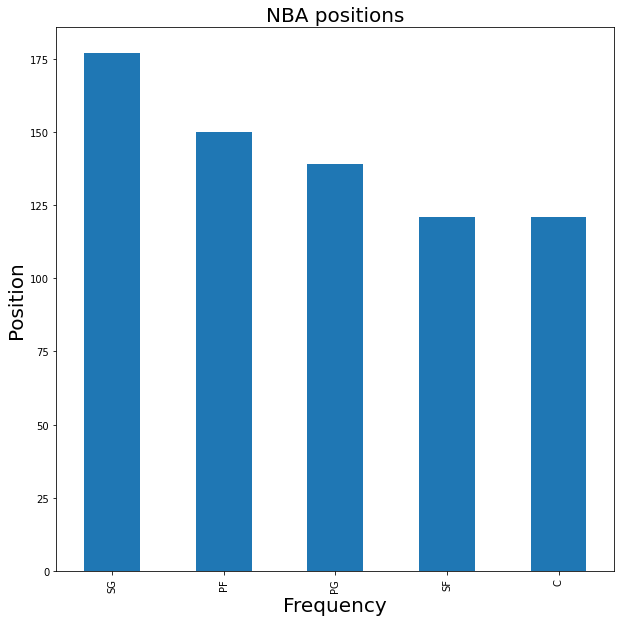

In [7]:
pos = NBA.Pos.value_counts()
plt.subplots(figsize=(10, 10))
pos.plot(kind="bar")
plt.title("NBA positions", fontsize=20 )
plt.xlabel("Frequency", fontsize =20)
plt.ylabel("Position", fontsize=20 )

The next issue is seeing if any players are duplicated because they siwtched throughout the season. From this we can see that there are 86 duplicated players. If we analyse these keeping teh duplciated players then this can potentially bias the results if they tilt the distribution towards a specific position. Therefore, we want to be able to remove the duplicates and put all the stats into a single row. 

In [8]:
duplicated_players = list(NBA[NBA.Player.duplicated(keep=False)].Player.unique())
print(len(duplicated_players))

86


To do this we need to check the columns and see how we may be able to aggregate them.

In [9]:
print(NBA.columns.values)

['Player' 'Pos' 'G' 'MP' 'FG' 'FGA' 'FG%' '3P' '3PA' '3P%' '2P' '2PA'
 '2P%' 'eFG%' 'FT' 'FTA' 'FT%' 'ORB' 'DRB' 'TRB' 'AST' 'STL' 'BLK' 'TOV'
 'PF' 'PTS']


The percentage columns will need to be dropped and we need to aggregate based on sum, and in the case of position, we will assume that the first position that is listed for that player remains the same.

In [10]:
NBA.drop(columns = ["3P%", "2P%", "FT%", "eFG%", "FG%"], inplace = True)

In [11]:
not_sum = ["Player", "Pos"]
agg_fun = {x: "sum" for x in [y for y in list(NBA.columns.values) if y not in not_sum]}
agg_fun["Pos"] = "first"


NBA = NBA.groupby(["Player"]).agg(agg_fun).reset_index()

We then want to check to see if any player, after aggregating, has limited number of games, say less than a quarter of the season. This may suggest that they got injured and so their numbers may be not representative, or that they were dropped part way through the season and as such have little importance to our analysis.

<AxesSubplot:>

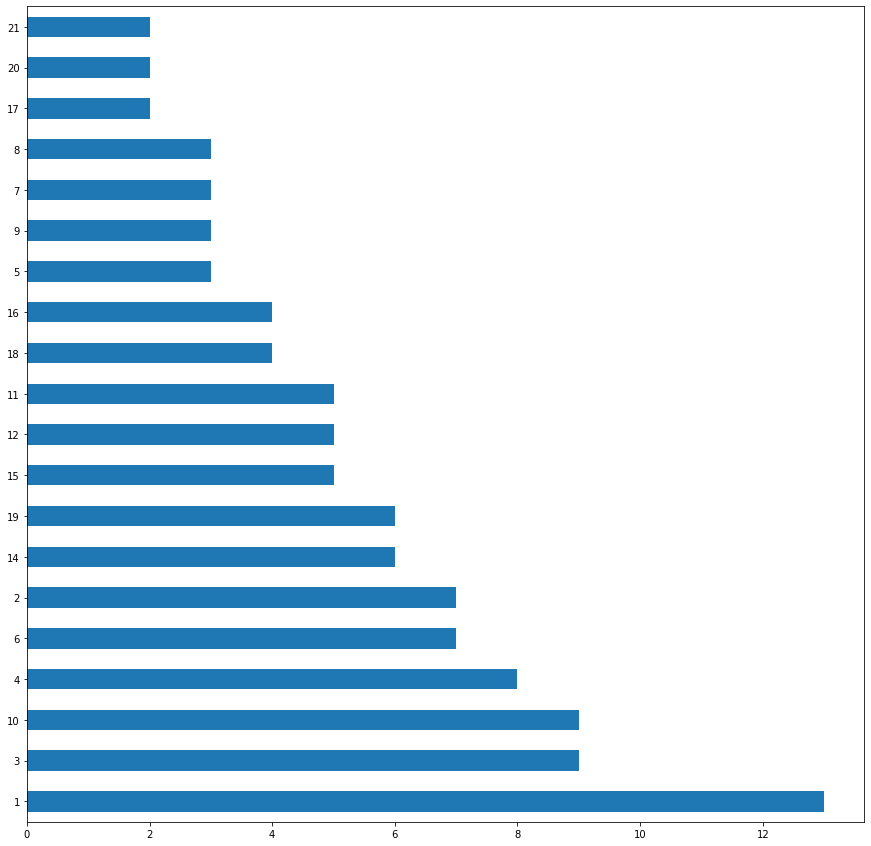

In [12]:
NBA[NBA.G <= 21].G.value_counts().plot(kind="barh", figsize=(15,15))

We can see from this distribution, and the value below, that a significnat number of players played less than 21 games. Given this number we can keep them for now but we need to be aware of how this may affect the results going forward.

In [13]:
count = 0
half_games = dict(NBA[NBA.G <= 21].G.value_counts())
for x in half_games.values():
    count += x

print(count)

106


Finally, we want to be able to add back in our percentage columns, that includes field goal percentage, 2P percentage, 3P percentage, free throw percentage and effective field goald percentage.

In [14]:
print(NBA.columns.values)

['Player' 'G' 'MP' 'FG' 'FGA' '3P' '3PA' '2P' '2PA' 'FT' 'FTA' 'ORB' 'DRB'
 'TRB' 'AST' 'STL' 'BLK' 'TOV' 'PF' 'PTS' 'Pos']


In [15]:
perc_cols = ["3P%", "2P%", "FT%", "FG%"]
for perc in perc_cols:
    made = str(perc[0:2])
    attempt = str(perc[0:2]) + "A"
    NBA[perc] = NBA[made]/NBA[attempt]

NBA["eFG%"] = (NBA["2P"] + 0.5*NBA["3P"])/NBA["FG"]

perc_cols.append("eFG%")

for x in perc_cols:
    NBA[x] = NBA[x].fillna(0)

Finally, given that these values are totals, apart form the percentage columns, they may be influenced by the number of games a player has played and how many minutes. For example, a star player may play a large number of games and minutes and thus will influence the game more than a role player at their position. A way to solve this is to divide each column by the minutes that a player plays so that the values are standardised to a degree. 

The results may show the efficiency of a player, but there is likely to be less variance than the overall results and so this should improve our analysis.

In [16]:
for x in [x for x in NBA.columns.values if x not in ["Player", "G", "MP", "Pos", "3P%", "2P%", "FT%", "FG%", "eFG%"]]:
    NBA[x] = NBA[x]/NBA["MP"]

In [17]:
NBA.describe()

,G,MP,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,STL,BLK,TOV,PF,PTS,3P%,2P%,FT%,FG%,eFG%
count,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,...,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000
mean,57.284906,1298.788679,0.154447,0.349445,0.041669,0.126529,0.112779,0.222915,0.062338,0.085013,...,0.031503,0.020024,0.052540,0.093216,0.412901,0.290279,0.491182,0.696771,0.439919,0.834618
std,35.407644,1051.133834,0.066636,0.111823,0.031308,0.084985,0.068961,0.109564,0.042405,0.054207,...,0.021052,0.020825,0.028753,0.041697,0.161563,0.149377,0.123924,0.214882,0.111814,0.163158
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,359.750000,0.120455,0.280456,0.018440,0.075461,0.069978,0.151091,0.033588,0.048913,...,0.021249,0.006711,0.035316,0.068950,0.323163,0.256824,0.453396,0.651580,0.402209,0.780730
50%,60.000000,1174.000000,0.147179,0.333874,0.042946,0.129738,0.102885,0.214913,0.056115,0.075772,...,0.029262,0.014380,0.048714,0.087582,0.398168,0.331550,0.500000,0.750000,0.438788,0.854026
75%,77.000000,2056.250000,0.187364,0.406053,0.059982,0.178306,0.148404,0.288225,0.083848,0.112659,...,0.038296,0.025641,0.064918,0.112943,0.495295,0.367566,0.552796,0.818182,0.489598,0.924928
max,164.000000,5694.000000,1.000000,1.000000,0.250000,1.000000,1.000000,1.000000,0.333333,0.363636,...,0.250000,0.166667,0.250000,0.461538,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can then remove the columns that we are not interested in analysing.

In [18]:
NBA.drop(columns = ["Player", "G", "MP"], inplace = True)

And begin to inspect our data in terms of the factors that may influence the analyis. This includes taking a look at any variables that may be correlated with each other anf thus unduly influence the analysis.

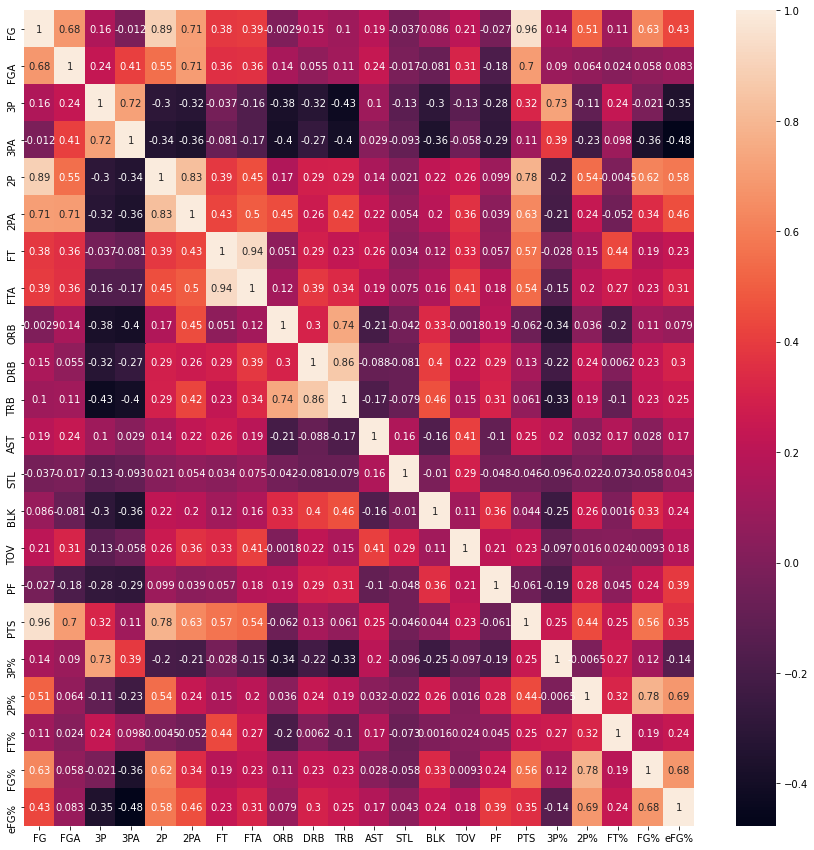

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

corrMatrix = NBA.corr()
f, (ax) = plt.subplots(figsize=(15,15))
sns.heatmap(corrMatrix, annot=True, ax=ax)
plt.show()


From this plot we can see that there are some variables that are highly correlated with each other. The solution we adopt here is to drop any columns that think may be less influential in our analysis or capture broader trends which other values may be able to differentiate between positions better.

In [20]:
NBA.drop(columns = ["FG", "FGA", "FG%", "FTA", "2PA", "3PA"], inplace = True)

We then want to extract the data that we will actually perform the classifier on. This means seperating it out into our X and Y values.

In [21]:
X = NBA.drop(columns = ["Pos"])
y = NBA.Pos

Which we then seperate into out train and test values for by y and x. We do this to ensure that the algorithm is not overfitting and see how it performs on unseen data.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## Dummy Classifier

In using the Random Forest Classifier we want to be able to test this against a baseline and we can do that by creating a dummy classifier. This dummy classifier makes decision based on simple decision rules, which in this case appears to be simply put all players into a shooting guard position, and thus has a relatively low accuracy of 0.28. This is our benchmark for going forward and analysing the results


In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics


dc = DummyClassifier(strategy='most_frequent', random_state = 42)
dc.fit(X_train,y_train) 
dc_preds = dc.predict(X_test)
print (metrics.classification_report(y_test, dc_preds))

              precision    recall  f1-score   support

           C       0.00      0.00      0.00        25
          PF       0.00      0.00      0.00        24
          PG       0.00      0.00      0.00        27
          SF       0.00      0.00      0.00        20
          SG       0.28      1.00      0.44        37

    accuracy                           0.28       133
   macro avg       0.06      0.20      0.09       133
weighted avg       0.08      0.28      0.12       133



C:\Users\phili\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## [Suppot Vector Machine](https://scikit-learn.org/stable/modules/svm.html)

Suppot Vector Machines are a set of supervised learning methods used for classification, regression and outlier detection.

The advantages of support vector machines are:
- Effective in high dimensional spaces
- Still effective in cases where number of dimensinos is greater than the number of samples
- Uses a subset of training points in the decision functions, so it is memory efficient
- Versatile

The disadvantages are:
- If the number of features is much greater than the number of samples avoid over-fitting in choosing Kernal functions and regularisation term is crucial
- SVMs do not directly provide probability estimates, hese are calcualted using expensive five-fold corss validation



In [38]:
from sklearn import svm

#choosing support vector machine
clf = svm.SVC(gamma = "auto", decision_function_shape = "ovo", kernel = "linear")
#training
clf.fit(X_train, y_train)
#Scoring
test_pred_svm = clf.predict(X_test)

In [39]:
y_test.value_counts()

SG    37
PG    27
C     25
PF    24
SF    20
Name: Pos, dtype: int64

In [40]:
conf_mat2 = metrics.confusion_matrix(y_test, test_pred_svm)

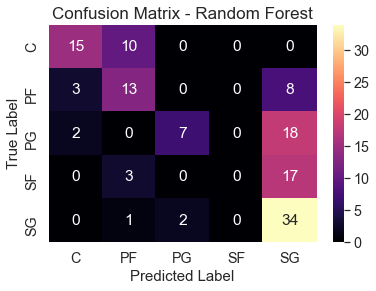

<Figure size 864x864 with 0 Axes>

In [41]:
matrix2_df = pd.DataFrame(conf_mat2)

# set axis to add title and axis labels later
ax = plt.axes()
sns.set(font_scale=1.3) # for label size
plt.figure(figsize=(12,12))

#fmt so that numbers aren't scientific
plot = sns.heatmap(matrix2_df, annot=True, fmt='g', ax=ax, cmap = "magma") 

#axis labels and title
ax.set_title('Confusion Matrix - Random Forest', fontsize = 17)
ax.set_xlabel('Predicted Label', fontsize = 15)
ax.set_ylabel('True Label'     , fontsize = 15)

# change tick labels from 0-4 to 1-5
labels = ("C", "PF", "PG", "SF", "SG")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()


fig = plot.get_figure()

In [43]:

print(metrics.classification_report(y_test, test_pred_svm))

              precision    recall  f1-score   support

           C       0.75      0.60      0.67        25
          PF       0.48      0.54      0.51        24
          PG       0.78      0.26      0.39        27
          SF       0.00      0.00      0.00        20
          SG       0.44      0.92      0.60        37

    accuracy                           0.52       133
   macro avg       0.49      0.46      0.43       133
weighted avg       0.51      0.52      0.46       133



C:\Users\phili\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)

In [114]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators = 100)

clf.fit(X_train, y_train)

test_pred_ada = clf.predict(X_test)

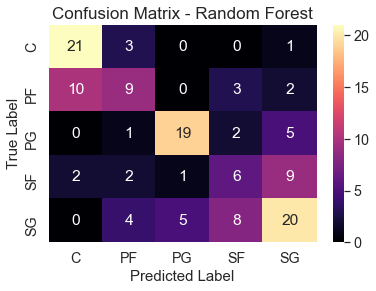

<Figure size 864x864 with 0 Axes>

In [115]:
conf_mat2 = metrics.confusion_matrix(y_test, test_pred_ada)

matrix2_df = pd.DataFrame(conf_mat2)

# set axis to add title and axis labels later
ax = plt.axes()
sns.set(font_scale=1.3) # for label size
plt.figure(figsize=(12,12))

#fmt so that numbers aren't scientific
plot = sns.heatmap(matrix2_df, annot=True, fmt='g', ax=ax, cmap = "magma") 

#axis labels and title
ax.set_title('Confusion Matrix - Random Forest', fontsize = 17)
ax.set_xlabel('Predicted Label', fontsize = 15)
ax.set_ylabel('True Label'     , fontsize = 15)

# change tick labels from 0-4 to 1-5
labels = ("C", "PF", "PG", "SF", "SG")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()


fig = plot.get_figure()

In [116]:
print(metrics.classification_report(y_test, test_pred_ada))

              precision    recall  f1-score   support

           C       0.64      0.84      0.72        25
          PF       0.47      0.38      0.42        24
          PG       0.76      0.70      0.73        27
          SF       0.32      0.30      0.31        20
          SG       0.54      0.54      0.54        37

    accuracy                           0.56       133
   macro avg       0.55      0.55      0.54       133
weighted avg       0.56      0.56      0.56       133



## Gradient boosting

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

lr_list = [x/100 for x in range(1,101, 2)]

acc_train = []
acc_val = []


for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators = 20, learning_rate = learning_rate,
                                       max_features =2, max_depth  =3, random_state = 42)
    gb_clf.fit(X_train, y_train)
    
    acc_train.append(np.round(gb_clf.score(X_train, y_train), 3))
    acc_val.append(np.round(gb_clf.score(X_test, y_test), 3))
    

GBC_dict = {"LR rate":lr_list, "Train score":acc_train, "Validation score":acc_val}

GBC_df = pd.DataFrame(GBC_dict)
GBC_df.sort_values(by = "LR rate", ascending=False, inplace=True)

<AxesSubplot:xlabel='LR rate'>

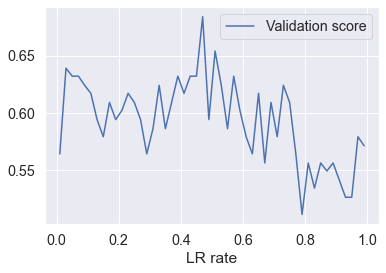

In [68]:
GBC_df.plot.line(x = "LR rate",  y = "Validation score")

## [Neural Network models](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification)

[Implementation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.fit)

In [108]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, activation = "logistic",
                   hidden_layer_sizes = (15), random_state = 42,
                   learning_rate  ="adaptive", early_stopping = True,
                   max_iter = 1000)

clf.fit(X_train, y_train)

C:\Users\phili\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', alpha=1e-05, early_stopping=True,
              hidden_layer_sizes=15, learning_rate='adaptive', max_iter=1000,
              random_state=42, solver='lbfgs')

In [109]:
test_pred_NN = clf.predict(X_test)

In [110]:
conf_mat2 = metrics.confusion_matrix(y_test, test_pred_NN)

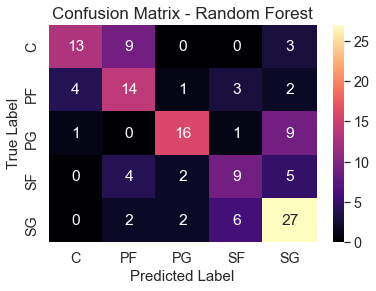

<Figure size 864x864 with 0 Axes>

In [111]:
matrix2_df = pd.DataFrame(conf_mat2)

# set axis to add title and axis labels later
ax = plt.axes()
sns.set(font_scale=1.3) # for label size
plt.figure(figsize=(12,12))

#fmt so that numbers aren't scientific
plot = sns.heatmap(matrix2_df, annot=True, fmt='g', ax=ax, cmap = "magma") 

#axis labels and title
ax.set_title('Confusion Matrix - Random Forest', fontsize = 17)
ax.set_xlabel('Predicted Label', fontsize = 15)
ax.set_ylabel('True Label'     , fontsize = 15)

# change tick labels from 0-4 to 1-5
labels = ("C", "PF", "PG", "SF", "SG")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()


fig = plot.get_figure()

In [112]:
print(metrics.classification_report(y_test, test_pred_NN))

              precision    recall  f1-score   support

           C       0.72      0.52      0.60        25
          PF       0.48      0.58      0.53        24
          PG       0.76      0.59      0.67        27
          SF       0.47      0.45      0.46        20
          SG       0.59      0.73      0.65        37

    accuracy                           0.59       133
   macro avg       0.61      0.58      0.58       133
weighted avg       0.61      0.59      0.59       133

